In [13]:
# Import basic
import pandas as pd
import numpy as np
import cv2
# Import plots
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# from keras.models import Sequential
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger

from importlib import reload
import visualization
import transformations
import model

from visualization import plots

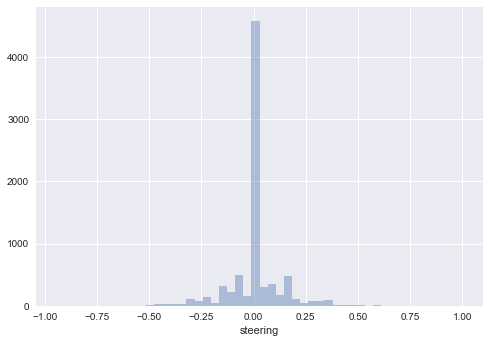

In [14]:
model_file = 'model.json'
model_weights = 'model.h5'
master = 'data/driving_log.csv'
data = pd.read_csv(master)
data = data.rename_axis(None)
data = shuffle(data)
sns.distplot(data['steering'], kde=False)
sns.plt.show()

In [3]:
train, validation = train_test_split(data, test_size=0.2, random_state=0)
print('TRAIN:', len(train))
print('VALIDATION:', len(validation))

BATCH_SIZE = 128

def generate_arrays_from_dataframe(data):
    while True:
        for offset in range(0, len(data), BATCH_SIZE):
            offset = 0
            batch = data[offset:offset+BATCH_SIZE]
            y = batch['steering'].values
            x = np.array([ cv2.imread('data/{}'.format(basename)) for basename in batch['center'].values])
            yield (x, y)

def normalize(image_data, a=-0.5, b = 0.5):
    grayscale_min = 0
    grayscale_max = 255
    return a + (((image_data - grayscale_min)*(b - a))/(grayscale_max - grayscale_min))

TRAIN: 6428
VALIDATION: 1608


In [4]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten
from keras.models import Model
import numpy as np

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(160, 320, 3))
x = base_model.output
# x = GlobalAveragePooling2D()(x)
x = Flatten(name='Flatten')(x)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu',  name='fc2')(x)
x = Dense(16, activation='relu',  name='fc3')(x)
predictions = Dense(1, name='readout')(x)
model = Model(input=base_model.input, output=predictions)

# img_input = Input(shape=(160, 320, 3))
# x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
# x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
# x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
# x = Flatten(name='flatten')(x)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
# x = Dense(1, name='predictions')(x)
# model = Model(img_input, x, name='vgg16')
# for layer in base_model.layers:
#     layer.trainable = False

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
print(model.summary())


# Saves the model...
with open('logs/model.json', 'w') as f:
    f.write(model.to_json())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 320, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 160, 320, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 160, 320, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 80, 160, 64)   0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [5]:
# checkpointer = ModelCheckpoint('checkpoints/weights.{epoch:02d}-{val_loss:.3f}.hdf5')
# logger = CSVLogger(filename='logs/training.log')

# model.fit_generator(generate_arrays_from_dataframe(train), \
#                     validation_data=generate_arrays_from_dataframe(validation), \
#                     nb_val_samples = len(validation),        \
#                     samples_per_epoch=250, nb_epoch=2,
#                     callbacks=[checkpointer, logger])

In [6]:
offset = 0
batch = data[offset:offset+BATCH_SIZE]
y = batch['throttle'].values
x = np.array([ cv2.imread('data/{}'.format(basename)) for basename in batch['center'].values])

In [7]:
# model.fit(x, y)

In [8]:
with open(model_file, 'r') as jfile:
    model = model_from_json(jfile.read())
model.compile("adam", "mse")
model.load_weights(model_weights)

NameError: name 'model_from_json' is not defined

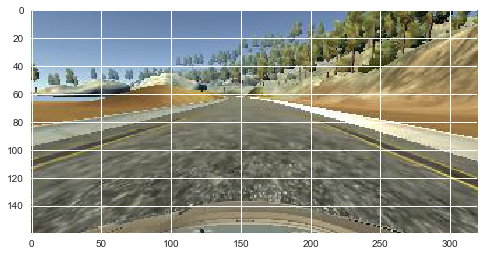

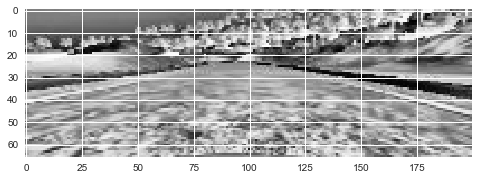

In [129]:
reload(transformations)
reload(loader)
import matplotlib.pyplot as plt
from keras.models import model_from_json
from transformations import Preproc
from loader import ReadImg

std = np.std(train['steering'])
sample = train[train['steering'] < +3*std].sample()
basename = sample['center'].item()
org_img = ReadImg('data/{}'.format(basename))
img = Preproc(org_img)
plt.subplots(1, 1)
plt.imshow(org_img)
plt.subplots(1, 1)
plt.imshow(img)
plt.show()
# img_input = np.expand_dims(img, axis=0)
# img = cv2.equalizeHist(img)
# clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(3,3))
# img = clahe.apply(img)
# plt.subplots(1, 1)
# plt.imshow(img)
# plt.show()
# pred = model.predict(img_input)
# print(sample['steering'].item(), pred, sample['center'].item())

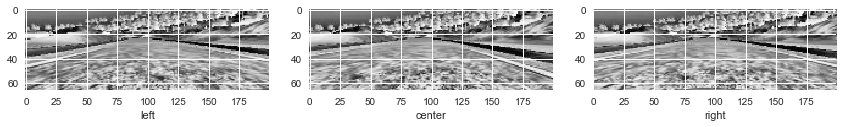

In [130]:
import loader
reload(loader)
from loader import ReadImg
left = Preproc(ReadImg('data/{}'.format(sample['left'].item().strip())))
center = Preproc(ReadImg('data/{}'.format(sample['center'].item().strip())))
right = Preproc(ReadImg('data/{}'.format(sample['right'].item().strip())))
images = [left, right, center]    
plots(images, 1, 3, figsize=(12, 9),labels=['left', 'center', 'right'])

In [118]:
reload(transformations)
reload(visualization)
from visualization import plots
from transformations import Rotate, Translate, Crop, Resize, Shift
plots([center, Shift(center, -60)], 1, 2, figsize=(12, 9), labels=['left', 'center', 'transf'], grid=True)

ValueError: not enough values to unpack (expected 3, got 2)

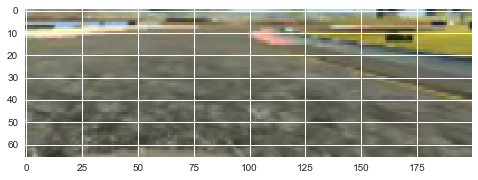

In [57]:
reload(transformations)
from transformations import Preproc
img = Preproc(center)
plt.imshow(img)
plt.show()

In [17]:
df = train[train['steering']<2*std].sample(5, replace=True)
print(df.shape)
df.append(train[train['steering']<2*std].sample(5, replace=True))
print(df.shape)
df = df.append(train[train['steering']<2*std].sample(5, replace=True))
print(df.shape)

(5, 7)
(5, 7)
(10, 7)


In [105]:
train[train['steering'] < +3*std].sample(1)['center']

7456    IMG/center_2016_12_01_13_45_42_990.jpg
Name: center, dtype: object

In [106]:
sample = train[train['steering'] < +2*std].sample()
sample2 = train[train['steering'] < +2*std].sample()
sample = sample.append(sample2)

sample

,center,left,right,steering,throttle,brake,speed,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
1774,IMG/center_2016_12_01_13_35_38_102.jpg,IMG/left_2016_12_01_13_35_38_102.jpg,IMG/right_2016_12_01_13_35_38_102.jpg,0.0,0.985533,0.0,30.18695,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13367,IMG/center_2017_01_29_02_45_54_522.jpg,NaN,NaN,0.0,0.400000,0.0,30.03858,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
sample['steering'].values

array([ 0.,  0.])

In [108]:
np.random.normal(0, 0.0001, 10000)
# zero = train[train['steering'] == 0]
# zero['steering'] = np.random.choice([np.random.normal(0, 0.0001)])
train.head()

,center,left,right,steering,throttle,brake,speed,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
8421,IMG/center_2017_01_28_21_04_45_005.jpg,NaN,NaN,-0.450000,0.400000,0.0,30.0292,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9901,IMG/center_2017_01_28_21_09_33_299.jpg,NaN,NaN,-0.266667,0.400000,0.0,30.02871,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8822,IMG/center_2017_01_28_21_07_04_922.jpg,NaN,NaN,0.000000,0.000000,0.0,4.515845,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6558,IMG/center_2016_12_01_13_44_11_946.jpg,IMG/left_2016_12_01_13_44_11_946.jpg,IMG/right_2016_12_01_13_44_11_946.jpg,0.000000,0.985533,0.0,30.18663,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12542,IMG/center_2017_01_29_02_44_32_952.jpg,NaN,NaN,0.000000,0.400000,0.0,13.53091,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


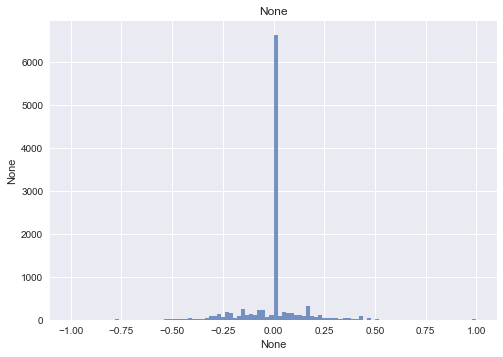

In [109]:
reload(visualization)
from visualization import hist
hist(train, 'steering')